In [213]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [58]:

import json
from itertools import islice
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from pts.dataset import recipe as rcp

from pts.dataset.artificial import RecipeDataset
from pts.dataset import FileDataset, MetaData

from pts.dataset.repository import get_dataset
from pts.evaluation import make_evaluation_predictions, Evaluator
from pts.model.deepar import DeepAREstimator
from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from pts.modules import (
    ImplicitQuantileOutput,
    PiecewiseLinearOutput,
)
from pts import Trainer



TIME_SERIE_LENGTH = 4 * 4 # 8736
PREDICTION_LENGTH = 3 #24
CONTEXT_LENGTH = 3 * 4 #96
NUMBER_OF_TIME_SERIES = 1024 * 2

NUM_EPOCHS = 20
NUM_BATCHES_PER_EPOCH = 16
NUM_TRAININGS = 1
NUM_SAMPLES = 100
BATCH_SIZE = 64 * 2


        
def write_to_file(recipe, length, num_ts, file_name):
    with open("{}.json".format(file_name), 'w') as f:
        for x in islice(rcp.generate(length, recipe, "2019-01-07 00:00"), num_ts):
            z = {}
            for k in x:
                if type(x[k]) == np.ndarray:
                    z[k] = x[k].tolist()
                else:
                    z[k] = x[k]
            f.write(json.dumps(z))
            f.write('\n')

            
class RandomGaussianMixture(rcp.Lifted):
    def __init__(
            self, mean, stddev, mixture_coef, shape=(0,)
    ) -> None:
        self.stddev = np.array(stddev).reshape(1, -1)
        self.mean = np.array(mean).reshape(1, -1)
        self.mixture_coef = mixture_coef
        self.shape = shape

    def __call__(self, x, length: int, *args, **kwargs):
        s = [length, self.stddev.shape[0]]
        choices = np.random.choice([0, 1, 2], p=self.mixture_coef, size=(length, ))
        all_samples = self.stddev * np.random.randn(*s) + self.mean
        result = np.zeros((length,))
        for i in range(length):
            c = choices[i]
            result[i] = all_samples[i, c]
        return result
        
        
DATASET_REFERENCES = {
#     "gaussian(4, 10)": 4 + rcp.RandomGaussian(stddev=10),
#     "random_int(0, 2)": rcp.RandomInteger(low=0., high=2.),
    "gaussian_mixture": RandomGaussianMixture(mean=[-3., 0, 3.], stddev=[0.4]*3, mixture_coef=[0.3, 0.4, 0.3], shape=(3,))
    
}    

META_DATA = MetaData(freq="H", prediction_length=PREDICTION_LENGTH)

for fn in DATASET_REFERENCES:
    recipe = [("input", 1.), ("target", DATASET_REFERENCES[fn])]
    
    write_to_file(recipe, length=TIME_SERIE_LENGTH, num_ts=NUMBER_OF_TIME_SERIES, file_name=fn)



In [59]:
def run_one_training(dataset, distr_output, metadata=META_DATA):
#     estimator = SimpleFeedForwardEstimator(
#         distr_output=distr_output,
#         freq=metadata.freq,
#         prediction_length=metadata.prediction_length,
#         num_hidden_dimensions=[10],
# #         context_length=CONTEXT_LENGTH,
#         trainer=Trainer(device="cpu",
#                         epochs=NUM_EPOCHS,
#                         learning_rate=1e-3,
#                         num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
#                         batch_size=BATCH_SIZE,
#                         num_workers=1,
#                         ),
#     )

    estimator = DeepAREstimator(
        distr_output=distr_output,
        freq=metadata.freq,
        prediction_length=metadata.prediction_length,
        trainer=Trainer(device="cpu",
                        epochs=NUM_EPOCHS,
                        learning_rate=1e-3,
                        num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                        batch_size=BATCH_SIZE,
                        num_workers=1,
                        ),
        input_size=48,
    )
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    
    all_quantiles_df = pd.DataFrame(
        [
            [forecasts[item_id].quantile(q/100.)[0] for q in range(0, 100)] 
            for item_id in range(len(forecasts))
        ]
    )
    sampled_quantiles = all_quantiles_df.mean(axis=0)
    return estimator, agg_metrics, sampled_quantiles


def run_several_training(dataset, distr_output, num_trainings=NUM_TRAININGS):
    estimators = []
    all_agg_metrics = []
    all_sampled_quantiles = []
    for i in range(num_trainings):
        estimator, agg_metrics, sampled_quantiles = run_one_training(dataset, distr_output)
        estimators.append(estimator)
        all_agg_metrics.append(agg_metrics)
        all_sampled_quantiles.append(sampled_quantiles)
        
    return estimators, all_agg_metrics, all_sampled_quantiles


store_results = {}
distr_outputs = {
    'iqn': ImplicitQuantileOutput(output_domain="Real"),
#     'piecewiseLinear_2': PiecewiseLinearOutput(num_pieces=2),
    'piecewiseLinear_5': PiecewiseLinearOutput(num_pieces=5),
#     'piecewiseLinear_10': PiecewiseLinearOutput(num_pieces=10),
    'piecewiseLinear_15': PiecewiseLinearOutput(num_pieces=15),
    'piecewiseLinear_30': PiecewiseLinearOutput(num_pieces=30),
    'piecewiseLinear_50': PiecewiseLinearOutput(num_pieces=50),
}


for fn in DATASET_REFERENCES:
    dataset = FileDataset("{}.json".format(fn), META_DATA.freq, shuffle=True)
    for dn in distr_outputs:
        distr_output = distr_outputs[dn]
        estimators, all_agg_metrics, all_sampled_quantiles = run_several_training(dataset, distr_output)
        store_results[(fn, dn)] = {
            "estimators": estimators,
            "all_agg_metrics": all_agg_metrics, 
            "all_sampled_quantiles": all_sampled_quantiles,
        }
        





15it [00:00, 19.17it/s, avg_epoch_loss=1.01, epoch=0]
15it [00:00, 16.08it/s, avg_epoch_loss=0.963, epoch=1]
15it [00:00, 16.05it/s, avg_epoch_loss=0.95, epoch=2] 
15it [00:00, 18.78it/s, avg_epoch_loss=0.94, epoch=3] 
15it [00:00, 18.78it/s, avg_epoch_loss=0.882, epoch=4]
15it [00:00, 16.89it/s, avg_epoch_loss=0.745, epoch=5]
15it [00:00, 18.11it/s, avg_epoch_loss=0.709, epoch=6]
15it [00:00, 18.44it/s, avg_epoch_loss=0.718, epoch=7]
15it [00:00, 18.79it/s, avg_epoch_loss=0.693, epoch=8]
15it [00:00, 19.44it/s, avg_epoch_loss=0.692, epoch=9]
15it [00:00, 19.79it/s, avg_epoch_loss=0.692, epoch=10]
15it [00:00, 19.75it/s, avg_epoch_loss=0.691, epoch=11]
15it [00:00, 19.65it/s, avg_epoch_loss=0.69, epoch=12] 
15it [00:00, 18.05it/s, avg_epoch_loss=0.687, epoch=13]
15it [00:00, 18.00it/s, avg_epoch_loss=0.675, epoch=14]
15it [00:00, 19.21it/s, avg_epoch_loss=0.688, epoch=15]
15it [00:00, 19.27it/s, avg_epoch_loss=0.685, epoch=16]
15it [00:00, 18.88it/s, avg_epoch_loss=0.685, epoch=17]
15i

In [60]:
def plot_quantile_functions(all_sampled_quantiles):
    for serie in all_sampled_quantiles:
        plt.plot(serie)

def summarize_metrics(all_agg_metrics):
    KEY_METRICS = ["MASE", "sMAPE", "MSIS"]
    agg_func = [np.mean, np.min, np.max]

    all_metrics = pd.DataFrame(all_agg_metrics)
    QUANTILE_METRICS = [c for c in all_metrics.columns if ("Coverage" in c) or ("wQuantile" in c)]
    
    display(all_metrics[KEY_METRICS].agg(agg_func, axis=0).T)
    display(all_metrics[QUANTILE_METRICS].agg(agg_func, axis=0).T)

    
def compare_trainings(store_results, dataset_reference=DATASET_REFERENCES):
    for fn in dataset_reference:
        true_distribution = dataset_reference[fn]
        random_values = rcp.evaluate([('target', true_distribution)], length=10000)['target']
        true_quantiles = [np.quantile(random_values, q=q/100) for q in range(0, 101)]
        
        for dn in distr_outputs:
            all_sampled_quantiles = store_results[(fn, dn)]["all_sampled_quantiles"]
            plt.plot(true_quantiles, color="black", linestyle='dashed',)
            plot_quantile_functions(all_sampled_quantiles)
            plt.legend(["True distribution"])
            plt.xlabel("Sampled quantile")
            plt.ylabel("Sampled value")
            plt.title("Distribution: {}, Estimator: {}".format(fn, dn))
            plt.show()

        for dn in distr_outputs:
            all_agg_metrics = store_results[(fn, dn)]["all_agg_metrics"]
            print("-------------------------------------------------")
            print("Distribution: {}, Estimator: {}".format(fn, dn))
            summarize_metrics(all_agg_metrics)


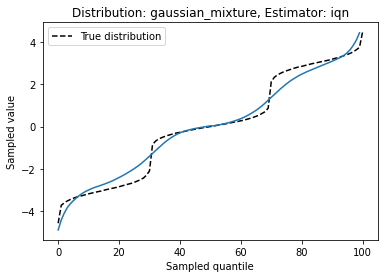

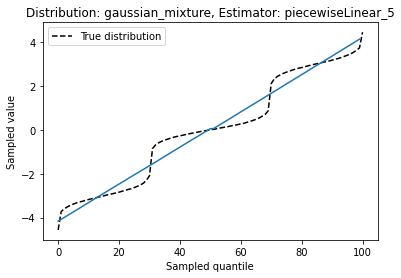

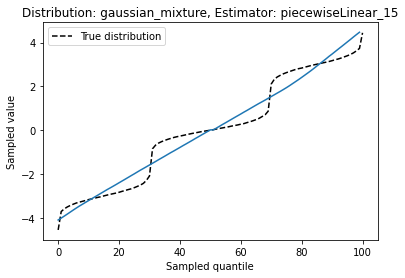

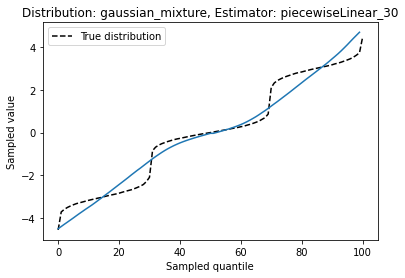

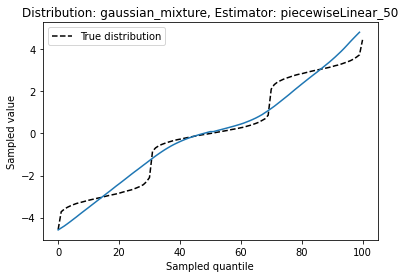

-------------------------------------------------
Distribution: gaussian_mixture, Estimator: iqn


,mean,amin,amax
MASE,0.787181,0.787181,0.787181
sMAPE,1.792778,1.792778,1.792778
MSIS,3.788567,3.788567,3.788567


,mean,amin,amax
Coverage[0.1],0.155599,0.155599,0.155599
Coverage[0.2],0.249512,0.249512,0.249512
Coverage[0.3],0.310547,0.310547,0.310547
Coverage[0.4],0.409668,0.409668,0.409668
Coverage[0.5],0.507161,0.507161,0.507161
Coverage[0.6],0.599935,0.599935,0.599935
Coverage[0.7],0.681315,0.681315,0.681315
Coverage[0.8],0.749023,0.749023,0.749023
Coverage[0.9],0.854004,0.854004,0.854004
wQuantileLoss[0.1],0.394740,0.394740,0.394740


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_5


,mean,amin,amax
MASE,0.804455,0.804455,0.804455
sMAPE,1.657454,1.657454,1.657454
MSIS,3.778710,3.778710,3.778710


,mean,amin,amax
Coverage[0.1],0.110352,0.110352,0.110352
Coverage[0.2],0.234701,0.234701,0.234701
Coverage[0.3],0.295573,0.295573,0.295573
Coverage[0.4],0.335612,0.335612,0.335612
Coverage[0.5],0.508626,0.508626,0.508626
Coverage[0.6],0.653971,0.653971,0.653971
Coverage[0.7],0.693522,0.693522,0.693522
Coverage[0.8],0.769368,0.769368,0.769368
Coverage[0.9],0.894531,0.894531,0.894531
wQuantileLoss[0.1],0.401142,0.401142,0.401142


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_15


,mean,amin,amax
MASE,0.806349,0.806349,0.806349
sMAPE,1.678923,1.678923,1.678923
MSIS,3.818138,3.818138,3.818138


,mean,amin,amax
Coverage[0.1],0.120605,0.120605,0.120605
Coverage[0.2],0.237793,0.237793,0.237793
Coverage[0.3],0.297852,0.297852,0.297852
Coverage[0.4],0.331868,0.331868,0.331868
Coverage[0.5],0.500000,0.500000,0.500000
Coverage[0.6],0.648926,0.648926,0.648926
Coverage[0.7],0.688802,0.688802,0.688802
Coverage[0.8],0.751790,0.751790,0.751790
Coverage[0.9],0.907064,0.907064,0.907064
wQuantileLoss[0.1],0.400101,0.400101,0.400101


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_30


,mean,amin,amax
MASE,0.790744,0.790744,0.790744
sMAPE,1.747548,1.747548,1.747548
MSIS,3.774962,3.774962,3.774962


,mean,amin,amax
Coverage[0.1],0.086914,0.086914,0.086914
Coverage[0.2],0.238932,0.238932,0.238932
Coverage[0.3],0.304036,0.304036,0.304036
Coverage[0.4],0.365560,0.365560,0.365560
Coverage[0.5],0.483236,0.483236,0.483236
Coverage[0.6],0.600586,0.600586,0.600586
Coverage[0.7],0.678060,0.678060,0.678060
Coverage[0.8],0.744466,0.744466,0.744466
Coverage[0.9],0.897461,0.897461,0.897461
wQuantileLoss[0.1],0.400537,0.400537,0.400537


-------------------------------------------------
Distribution: gaussian_mixture, Estimator: piecewiseLinear_50


,mean,amin,amax
MASE,0.790894,0.790894,0.790894
sMAPE,1.728450,1.728450,1.728450
MSIS,3.855967,3.855967,3.855967


,mean,amin,amax
Coverage[0.1],0.091309,0.091309,0.091309
Coverage[0.2],0.243815,0.243815,0.243815
Coverage[0.3],0.307943,0.307943,0.307943
Coverage[0.4],0.390462,0.390462,0.390462
Coverage[0.5],0.527669,0.527669,0.527669
Coverage[0.6],0.626953,0.626953,0.626953
Coverage[0.7],0.682617,0.682617,0.682617
Coverage[0.8],0.744141,0.744141,0.744141
Coverage[0.9],0.916016,0.916016,0.916016
wQuantileLoss[0.1],0.406677,0.406677,0.406677


In [61]:
compare_trainings(store_results)